![](nlfff.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from sunpy.map import Map
from astropy.table import Table

In [2]:
class nlfff:

      def __init__(self,filename):
            self.filename=filename

            nc=netCDF4.Dataset(self.filename,'r')
            self.NOAA=nc.NOAA
            self.year_month_day_time=nc.year_month_day_time
            self.project=nc.project
            self.production_date=nc.production_date
            self.version=nc.version
            self.data_doi=nc.data_doi
            self.http_link=nc.http_link
            self.Distributor=nc.Distributor
            
            nc_x=nc.variables['x']
            self.x=nc_x[:]
            print(nc_x.long_name,' unit:',nc_x.units)
            nc_y=nc.variables['y']
            self.y=nc_y[:]
            print(nc_y.long_name,' unit:',nc_y.units)
            nc_z=nc.variables['z']
            self.z=nc_z[:]
            print(nc_z.long_name,' unit:',nc_z.units)
            
            nc_bx=nc.variables['Bx']
            self.bx=nc_bx[:].transpose(2,1,0)
            print(nc_bx.long_name,' unit:',nc_bx.units)
            nc_by=nc.variables['By']
            self.by=nc_by[:].transpose(2,1,0)
            print(nc_by.long_name,' unit:',nc_by.units)
            nc_bz=nc.variables['Bz']
            self.bz=nc_bz[:].transpose(2,1,0)
            print(nc_bz.long_name,' unit:',nc_bz.units)
            
            nc_bxp=nc.variables['Bx_pot']
            self.bx_pot=nc_bxp[:].transpose(2,1,0)
            print(nc_bxp.long_name,' unit:',nc_bxp.units)
            nc_byp=nc.variables['By_pot']
            self.by_pot=nc_byp[:].transpose(2,1,0)
            print(nc_byp.long_name,' unit:',nc_byp.units)
            nc_bzp=nc.variables['Bz_pot']
            self.bz_pot=nc_bzp[:].transpose(2,1,0)
            print(nc_bzp.long_name,' unit:',nc_bzp.units)
            
      def info(self):
            self.Lx_Mm=max(self.x) - min(self.x)
            self.Ly_Mm=max(self.y) - min(self.y)
            print(f'(Lx, Ly) in Mm = ({self.Lx_Mm:.2f}, {self.Ly_Mm:.2f})\n')
            print(f"NOAA",self.NOAA)
            print(f'year_month_day_time',self.year_month_day_time)
            print(f"project",self.project)
            print(f"production_date",self.production_date)
            print(f"version",self.version)
            print(f"data_doi",self.data_doi)
            print(f"http_link",self.http_link)
            print(f"Distributor",self.Distributor)

      def plot(self):
            xs=12.0
            ys=4.0

            xmin=min(self.x)
            xmax=max(self.x)
            ymin=min(self.y)
            ymax=max(self.y)

            plt.close()
            fig=plt.figure(figsize=(xs,ys))
            ax1=fig.add_axes((0.08,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            ax2=fig.add_axes((0.4,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            ax3=fig.add_axes((0.72,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            cax1=fig.add_axes((0.08,0.15,0.25,0.05))
            cax2=fig.add_axes((0.4,0.15,0.25,0.05))
            cax3=fig.add_axes((0.72,0.15,0.25,0.05))
            
            vmin=-3000.0 
            vmax=3000.0
            
            im1=ax1.pcolormesh(self.x,self.y,self.bx[:,:,0].transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')
            im2=ax2.pcolormesh(self.x,self.y,self.by[:,:,0].transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')
            im3=ax3.pcolormesh(self.x,self.y,self.bz[:,:,0].transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')

            cbar1=plt.colorbar(im1,cax=cax1,orientation='horizontal')
            cbar2=plt.colorbar(im2,cax=cax2,orientation='horizontal')
            cbar3=plt.colorbar(im3,cax=cax3,orientation='horizontal')
            
            ax1.set_title('Bx [G]')
            ax1.set_xlabel('x [Mm]')
            ax1.set_ylabel('y [Mm]')
            
            ax2.set_title('By [G]')
            ax2.set_xlabel('x [Mm]')
            ax2.set_ylabel('y [Mm]')
            
            ax3.set_title('Bz [G]')
            ax3.set_xlabel('x [Mm]')
            ax3.set_ylabel('y [Mm]')
            
            #plt.pause(0.1)
            # plt.savefig('./B.png')


In [3]:
data = nlfff('12673_20170905_202400.nc')

x (westward)  unit: Mm
y (northward)  unit: Mm
z (out ot photosphere)  unit: Mm
Bx (westward)  unit: G
By (northward)  unit: G
Bz (out of photosphere)  unit: G
Bx_pot (westward)  unit: G
By_pot (northward)  unit: G
Bz_pot (out of photosphere)  unit: G


In [4]:
import os
import time
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from tqdm import trange
from jax import jvp, value_and_grad
from flax import linen as nn
from typing import Sequence
from functools import partial

In [33]:
# class SPINN(nn.Module):
#     features: Sequence[int]

#     @nn.compact
#     def __call__(self, x, y, z):
#         inputs, outputs = [x, y, z], []
#         init = nn.initializers.glorot_normal()
#         for X in inputs:
#             for fs in self.features[:-1]:
#                 X = nn.Dense(fs, kernel_init=init)(X)
#                 X = nn.activation.tanh(X)
#             X = nn.Dense(self.features[-1], kernel_init=init)(X)
#             outputs += [jnp.transpose(X, (1, 0))]
#         xy = jnp.einsum('fx, fy->fxy', outputs[0], outputs[1])
#         bx = jnp.einsum('fxy, fz->xyz', xy, outputs[-1])
        
#         inputs, outputs = [x, y, z], []
#         init = nn.initializers.glorot_normal()
#         for X in inputs:
#             for fs in self.features[:-1]:
#                 X = nn.Dense(fs, kernel_init=init)(X)
#                 X = nn.activation.tanh(X)
#             X = nn.Dense(self.features[-1], kernel_init=init)(X)
#             outputs += [jnp.transpose(X, (1, 0))]
#         xy = jnp.einsum('fx, fy->fxy', outputs[0], outputs[1])
#         by = jnp.einsum('fxy, fz->xyz', xy, outputs[-1])
        
#         inputs, outputs = [x, y, z], []
#         init = nn.initializers.glorot_normal()
#         for X in inputs:
#             for fs in self.features[:-1]:
#                 X = nn.Dense(fs, kernel_init=init)(X)
#                 X = nn.activation.tanh(X)
#             X = nn.Dense(self.features[-1], kernel_init=init)(X)
#             outputs += [jnp.transpose(X, (1, 0))]
#         xy = jnp.einsum('fx, fy->fxy', outputs[0], outputs[1])
#         bz = jnp.einsum('fxy, fz->xyz', xy, outputs[-1])
#         return jnp.stack([bx, by, bz], axis=0)

# class SPINN(nn.Module):
#     features: Sequence[int]

#     @nn.compact
#     def __call__(self, x, y, z):
#         inputs, outputs = [x, y, z], []
#         init = nn.initializers.glorot_normal()
#         for X in inputs:
#             for fs in self.features[:-1]:
#                 X = nn.Dense(fs, kernel_init=init)(X)
#                 X = nn.activation.tanh(X)
#             X = nn.Dense(self.features[-1], kernel_init=init)(X)
#             outputs += [jnp.transpose(X, (1, 0))]
#         xy = jnp.einsum('fx, fy->fxy', outputs[0], outputs[1])
#         return jnp.einsum('fxy, fz->fxyz', xy, outputs[-1])

class SPINN(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x, y, z):
        inputs, outputs = [x, y, z], []
        init = nn.initializers.glorot_normal()
        for X in inputs:
            for fs in self.features[:-1]:
                K = nn.Dense(fs, kernel_init=init)(X)
                K = nn.activation.tanh(K)
            K = nn.Dense(self.features[-1], kernel_init=init)(K)
            for fs in self.features[:-1]:
                L = nn.Dense(fs, kernel_init=init)(X)
                L = nn.activation.tanh(L)
            L = nn.Dense(self.features[-1], kernel_init=init)(L)
            for fs in self.features[:-1]:
                M = nn.Dense(fs, kernel_init=init)(X)
                M = nn.activation.tanh(M)
            M = nn.Dense(self.features[-1], kernel_init=init)(M)
            outputs += [[jnp.transpose(L, (1, 0)), jnp.transpose(K, (1, 0)), jnp.transpose(M, (1, 0))]]
        xy = jnp.einsum('fx, fy->fxy', outputs[0][0], outputs[1][0])
        bx = jnp.einsum('fxy, fz->xyz', xy, outputs[2][0])

        xy = jnp.einsum('fx, fy->fxy', outputs[0][1], outputs[1][1])
        by = jnp.einsum('fxy, fz->xyz', xy, outputs[2][1])

        xy = jnp.einsum('fx, fy->fxy', outputs[0][2], outputs[1][2])
        bz = jnp.einsum('fxy, fz->xyz', xy, outputs[2][2])
        return jnp.stack([bx, by, bz], axis=0)

@partial(jax.jit, static_argnums=(0,))
def update_model(optim, gradient, params, state):
    updates, state = optim.update(gradient, state)
    params = optax.apply_updates(params, updates)
    return params, state

def train_data_generator(nc, key, b):
    keys = jax.random.split(key, 3)

    xc = jax.random.uniform(keys[0], (nc, 1), minval=0., maxval=512)
    yc = jax.random.uniform(keys[1], (nc, 1), minval=0., maxval=256)
    zc = jax.random.uniform(keys[2], (nc, 1), minval=0., maxval=256)
    # xc_m, yc_m, zc_m = jnp.meshgrid(xc.ravel(), yc.ravel(), zc.ravel(), indexing='ij')
    # uc = jnp.zeros(xc_m.shape)

    # xb_p = jnp.arange(0, 513).reshape(-1, 1)
    # yb_p = jnp.arange(0, 257).reshape(-1, 1)
    # zb_p = jnp.arange(0, 257).reshape(-1, 1)

    # xb = [jnp.array([[0]]),
    #       jnp.array([[512]]),
    #       xb_p,
    #       xb_p,
    #       xb_p,
    #       xb_p,]
    # yb = [yb_p,
    #       yb_p,
    #       jnp.array([[0]]),
    #       jnp.array([[256]]),
    #       yb_p,
    #       yb_p,]
    # zb = [zb_p,
    #       zb_p,
    #       zb_p,
    #       zb_p,
    #       jnp.array([[0]]),
    #       jnp.array([[256]]),]

    # ub = [b[:, 0, :, :]]
    # ub += [b[:, 512, :, :]]
    # ub += [b[:, :, 0, :]]
    # ub += [b[:, :, 256, :]]
    # ub += [b[:, :, :, 0]]
    # ub += [b[:, :, :, 256]]


    xb_p = jax.random.randint(keys[3], (nc, 1), minval=0, maxval=512)
    yb_p = jax.random.randint(keys[4], (nc, 1), minval=0, maxval=256)
    zb_p = jax.random.randint(keys[5], (nc, 1), minval=0, maxval=256)

    xb = [jnp.array([[0]]),
          jnp.array([[512]]),
          xb_p,
          xb_p,
          xb_p,
          xb_p,]
    yb = [yb_p,
          yb_p,
          jnp.array([[0]]),
          jnp.array([[256]]),
          yb_p,
          yb_p,]
    zb = [zb_p,
          zb_p,
          zb_p,
          zb_p,
          jnp.array([[0]]),
          jnp.array([[256]]),]
    
    return xc, yc, zc, xb, yb, zb, b


def loss_nlfff(apply_fn, *train_data):
    def pde_loss(params, xc, yc, zc):
        v = jnp.ones(xc.shape)
        bx, bx_x = jvp(lambda x: apply_fn(params, x, yc, zc)[0, ...], (xc,), (v,))
        bx, bx_y = jvp(lambda y: apply_fn(params, xc, y, zc)[0, ...], (yc,), (v,))
        bx, bx_z = jvp(lambda z: apply_fn(params, xc, yc, z)[0, ...], (zc,), (v,))

        by, by_x = jvp(lambda x: apply_fn(params, x, yc, zc)[1, ...], (xc,), (v,))
        by, by_y = jvp(lambda y: apply_fn(params, xc, y, zc)[1, ...], (yc,), (v,))
        by, by_z = jvp(lambda z: apply_fn(params, xc, yc, z)[1, ...], (zc,), (v,))

        bz, bz_x = jvp(lambda x: apply_fn(params, x, yc, zc)[2, ...], (xc,), (v,))
        bz, bz_y = jvp(lambda y: apply_fn(params, xc, y, zc)[2, ...], (yc,), (v,))
        bz, bz_z = jvp(lambda z: apply_fn(params, xc, yc, z)[2, ...], (zc,), (v,))

        x_comp = ((bx_z - bz_x)*bz - (by_x-bx_y)*by)**2
        y_comp = ((by_x - bx_y)*bx - (bz_y-by_z)*bz)**2
        z_comp = ((bz_y - by_z)*by - (bx_z-bz_x)*bx)**2

        div = (bx_x + by_y + bz_z)**2
        return jnp.mean(div)
    
    def boundary_loss(params, xb, yb, zb, b):
        b_nn = apply_fn(params, xb[4], yb[4], zb[4]).squeeze()
        b_nn_z = b_nn[2, ...].ravel()
        b_bc = b[:, xb[4].ravel(), yb[4].ravel(), zb[4].ravel()]
        b_bc_z = b_bc[2, ...].ravel()
        loss = jnp.mean((b_nn_z - b_bc_z)**2)

        # loss = 0.
        # for i in range(6):
        #     b_nn = apply_fn(params, xb[i], yb[i], zb[i]).squeeze().ravel()
        #     xb_m, yb_m, zb_m = np.meshgrid(xb[i], yb[i], zb[i], indexing='ij')
        #     b_bc = b[:, xb_m.ravel(), yb_m.ravel(), zb_m.ravel()].ravel()
        #     loss += (1/6.)*jnp.mean((b_nn - b_bc)**2)

            # b_nn = apply_fn(params, xb[i], yb[i], zb[i]).squeeze()
            # b_bc = ub[i]
            # losses = (b_nn[0, ...] - b_bc[0, ...])**2 + (b_nn[1, ...] - b_bc[1, ...])**2 + (b_nn[2, ...] - b_bc[2, ...])**2
            # loss += (1/6.)*jnp.mean(losses)
            # loss += (1/6.)*jnp.mean((apply_fn(params, xb[i], yb[i], zb[i]).squeeze() - b[:, xb[i].ravel(), yb[i].ravel(), zb[i].ravel()])**2)
        return loss

    xc, yc, zc, xb, yb, zb, b = train_data 

    # fn = lambda params: 1e6*pde_loss(params, xc, yc, zc) + (1/1000.)*boundary_loss(params, xb, yb, zb, b)
    fn = lambda params: (1/1000.)*boundary_loss(params, xb, yb, zb, b)
    return fn


In [34]:
NC = 64
NB = 64
NC_TEST = 100
SEED = 444
LR = 1e-4
EPOCHS = 1000
N_LAYERS = 4
FEATURES = 128
LOG_ITER = 100

In [35]:
key = jax.random.PRNGKey(SEED)

key, subkey = jax.random.split(key, 2)
# feat_sizes = list(FEATURES for _ in range(N_LAYERS)) + [3]
feat_sizes = tuple(FEATURES for _ in range(N_LAYERS))
model = SPINN(feat_sizes)
params = model.init(subkey, jnp.ones((NC, 1)), jnp.ones((NC, 1)), jnp.ones((NC, 1)))

optim = optax.adam(LR)
state = optim.init(params)

key, subkey = jax.random.split(key, 2)
b = np.stack([np.array(data.bx), np.array(data.by), np.array(data.bz)], axis=0)
train_data = train_data_generator(NC, subkey, b)
# xt, yt, zt = test_data_generator(NC_TEST)

apply_fn = jax.jit(model.apply)

In [36]:
EPOCHS = 5000
LOG_ITER = 1000

In [37]:
loss_fn = loss_nlfff(apply_fn, *train_data)
@jax.jit
def train_one_step(params, state):
    # compute loss and gradient
    loss, gradient = value_and_grad(loss_fn)(params)
    # update state
    params, state = update_model(optim, gradient, params, state)
    return loss, params, state

start = time.time()
for e in trange(1, EPOCHS+1):
    # single run
    loss, params, state = train_one_step(params, state)
    # if e % 100 == 0 and e < 1000:
        # u = apply_fn(params, xt, yt)
        # plot_u(xt_m, yt_m, u, e)
    if e % LOG_ITER == 0:
        print(f'Epoch: {e}/{EPOCHS} --> loss: {loss:.8f}')
end = time.time()
print(f'Runtime: {((end-start)/EPOCHS*1000):.2f} ms/iter.')

  0%|          | 0/5000 [00:00<?, ?it/s]


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(int32[64])>with<DynamicJaxprTrace(level=1/0)>
The error occurred while tracing the function train_one_step at /var/folders/d4/xhfvv5n927b6pg81whlh7qxr0000gn/T/ipykernel_15418/1567112870.py:2 for jit. This value became a tracer due to JAX operations on these lines:

  operation a[35m:f32[3,64,64,1][39m b[35m:f32[64,1][39m c[35m:f32[64,128][39m d[35m:f32[64,128][39m e[35m:f32[64,1][39m f[35m:f32[64,128][39m
  g[35m:f32[64,128][39m h[35m:f32[128,64][39m i[35m:f32[128,64][39m j[35m:f32[1,1][39m k[35m:f32[1,128][39m l[35m:f32[1,128][39m
  m[35m:f32[128,1][39m n[35m:f32[128,64,64][39m o[35m:f32[64,1][39m p[35m:f32[64,128][39m q[35m:f32[64,128][39m r[35m:f32[64,1][39m
  s[35m:f32[64,128][39m t[35m:f32[64,128][39m u[35m:f32[128,64][39m v[35m:f32[128,64][39m w[35m:f32[1,1][39m x[35m:f32[1,128][39m
  y[35m:f32[1,128][39m z[35m:f32[128,1][39m ba[35m:f32[128,64,64][39m bb[35m:f32[64,1][39m bc[35m:f32[64,128][39m bd[35m:f32[64,128][39m
  be[35m:f32[64,1][39m bf[35m:f32[64,128][39m bg[35m:f32[64,128][39m bh[35m:f32[128,64][39m bi[35m:f32[128,64][39m bj[35m:f32[1,1][39m
  bk[35m:f32[1,128][39m bl[35m:f32[1,128][39m bm[35m:f32[128,1][39m bn[35m:f32[128,64,64][39m = pjit[
  jaxpr={ [34m[22m[1mlambda [39m[22m[22m; bo[35m:f32[128][39m bp[35m:f32[1,128][39m bq[35m:f32[128][39m br[35m:f32[1,128][39m bs[35m:f32[128][39m
      bt[35m:f32[1,128][39m bu[35m:f32[128][39m bv[35m:f32[128,128][39m bw[35m:f32[128][39m bx[35m:f32[1,128][39m by[35m:f32[128][39m
      bz[35m:f32[1,128][39m ca[35m:f32[128][39m cb[35m:f32[1,128][39m cc[35m:f32[128][39m cd[35m:f32[128,128][39m ce[35m:f32[128][39m
      cf[35m:f32[1,128][39m cg[35m:f32[128][39m ch[35m:f32[1,128][39m ci[35m:f32[128][39m cj[35m:f32[1,128][39m ck[35m:f32[128][39m
      cl[35m:f32[128,128][39m cm[35m:f32[128][39m cn[35m:f32[1,128][39m co[35m:f32[128][39m cp[35m:f32[1,128][39m cq[35m:f32[128][39m
      cr[35m:f32[1,128][39m cs[35m:f32[128][39m ct[35m:f32[1,128][39m cu[35m:f32[128][39m cv[35m:f32[128,128][39m cw[35m:f32[128][39m
      cx[35m:f32[1,128][39m cy[35m:f32[128][39m cz[35m:f32[1,128][39m da[35m:f32[128][39m db[35m:f32[1,128][39m dc[35m:f32[128][39m
      dd[35m:f32[128,128][39m de[35m:f32[128][39m df[35m:f32[1,128][39m dg[35m:f32[128][39m dh[35m:f32[1,128][39m di[35m:f32[128][39m
      dj[35m:f32[128,128][39m dk[35m:f32[128][39m dl[35m:f32[1,128][39m dm[35m:f32[128][39m dn[35m:f32[128,128][39m do[35m:f32[128][39m
      dp[35m:f32[1,128][39m dq[35m:f32[128][39m dr[35m:f32[1,128][39m ds[35m:f32[128][39m dt[35m:f32[1,128][39m du[35m:f32[128][39m
      dv[35m:f32[128,128][39m dw[35m:f32[128][39m dx[35m:f32[1,128][39m dy[35m:f32[128][39m dz[35m:f32[1,128][39m ea[35m:f32[128][39m
      eb[35m:f32[1,128][39m ec[35m:f32[128][39m ed[35m:f32[128,128][39m ee[35m:f32[128][39m ef[35m:f32[1,128][39m eg[35m:f32[128][39m
      eh[35m:f32[1,128][39m ei[35m:i32[64,1][39m ej[35m:i32[64,1][39m ek[35m:i32[1,1][39m. [34m[22m[1mlet
      [39m[22m[22mel[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ei
      em[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] el bp
      en[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] bo
      eo[35m:f32[64,128][39m = add em en
      ep[35m:f32[64,128][39m = tanh eo
      _[35m:f32[64,128][39m = sub 1.0 ep
      eq[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ei
      er[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] eq br
      es[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] bq
      et[35m:f32[64,128][39m = add er es
      eu[35m:f32[64,128][39m = tanh et
      _[35m:f32[64,128][39m = sub 1.0 eu
      ev[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ei
      ew[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] ev cn
      ex[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] cm
      ey[35m:f32[64,128][39m = add ew ex
      ez[35m:f32[64,128][39m = tanh ey
      fa[35m:f32[64,128][39m = sub 1.0 ez
      fb[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] ez dj
      fc[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] di
      fd[35m:f32[64,128][39m = add fb fc
      fe[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ei
      ff[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] fe dx
      fg[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] dw
      fh[35m:f32[64,128][39m = add ff fg
      fi[35m:f32[64,128][39m = tanh fh
      _[35m:f32[64,128][39m = sub 1.0 fi
      fj[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ei
      fk[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] fj dz
      fl[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] dy
      fm[35m:f32[64,128][39m = add fk fl
      fn[35m:f32[64,128][39m = tanh fm
      _[35m:f32[64,128][39m = sub 1.0 fn
      fo[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ei
      fp[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] fo eb
      fq[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] ea
      fr[35m:f32[64,128][39m = add fp fq
      fs[35m:f32[64,128][39m = tanh fr
      ft[35m:f32[64,128][39m = sub 1.0 fs
      fu[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] fs ed
      fv[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] ec
      fw[35m:f32[64,128][39m = add fu fv
      fx[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ei
      fy[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] fx ef
      fz[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] ee
      ga[35m:f32[64,128][39m = add fy fz
      gb[35m:f32[64,128][39m = tanh ga
      _[35m:f32[64,128][39m = sub 1.0 gb
      gc[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ei
      gd[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] gc eh
      ge[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] eg
      gf[35m:f32[64,128][39m = add gd ge
      gg[35m:f32[64,128][39m = tanh gf
      _[35m:f32[64,128][39m = sub 1.0 gg
      gh[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ei
      gi[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] gh bt
      gj[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] bs
      gk[35m:f32[64,128][39m = add gi gj
      gl[35m:f32[64,128][39m = tanh gk
      gm[35m:f32[64,128][39m = sub 1.0 gl
      gn[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] gl bv
      go[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] bu
      gp[35m:f32[64,128][39m = add gn go
      gq[35m:f32[128,64][39m = transpose[permutation=(1, 0)] fw
      gr[35m:f32[128,64][39m = transpose[permutation=(1, 0)] fd
      gs[35m:f32[128,64][39m = transpose[permutation=(1, 0)] gp
      gt[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ej
      gu[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] gt bx
      gv[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] bw
      gw[35m:f32[64,128][39m = add gu gv
      gx[35m:f32[64,128][39m = tanh gw
      _[35m:f32[64,128][39m = sub 1.0 gx
      gy[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ej
      gz[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] gy bz
      ha[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] by
      hb[35m:f32[64,128][39m = add gz ha
      hc[35m:f32[64,128][39m = tanh hb
      _[35m:f32[64,128][39m = sub 1.0 hc
      hd[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ej
      he[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] hd cb
      hf[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] ca
      hg[35m:f32[64,128][39m = add he hf
      hh[35m:f32[64,128][39m = tanh hg
      hi[35m:f32[64,128][39m = sub 1.0 hh
      hj[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] hh cd
      hk[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] cc
      hl[35m:f32[64,128][39m = add hj hk
      hm[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ej
      hn[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] hm cf
      ho[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] ce
      hp[35m:f32[64,128][39m = add hn ho
      hq[35m:f32[64,128][39m = tanh hp
      _[35m:f32[64,128][39m = sub 1.0 hq
      hr[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ej
      hs[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] hr ch
      ht[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] cg
      hu[35m:f32[64,128][39m = add hs ht
      hv[35m:f32[64,128][39m = tanh hu
      _[35m:f32[64,128][39m = sub 1.0 hv
      hw[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ej
      hx[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] hw cj
      hy[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] ci
      hz[35m:f32[64,128][39m = add hx hy
      ia[35m:f32[64,128][39m = tanh hz
      ib[35m:f32[64,128][39m = sub 1.0 ia
      ic[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] ia cl
      id[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] ck
      ie[35m:f32[64,128][39m = add ic id
      if[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ej
      ig[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] if cp
      ih[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] co
      ii[35m:f32[64,128][39m = add ig ih
      ij[35m:f32[64,128][39m = tanh ii
      _[35m:f32[64,128][39m = sub 1.0 ij
      ik[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ej
      il[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] ik cr
      im[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] cq
      in[35m:f32[64,128][39m = add il im
      io[35m:f32[64,128][39m = tanh in
      _[35m:f32[64,128][39m = sub 1.0 io
      ip[35m:f32[64,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ej
      iq[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] ip ct
      ir[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] cs
      is[35m:f32[64,128][39m = add iq ir
      it[35m:f32[64,128][39m = tanh is
      iu[35m:f32[64,128][39m = sub 1.0 it
      iv[35m:f32[64,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] it cv
      iw[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] cu
      ix[35m:f32[64,128][39m = add iv iw
      iy[35m:f32[128,64][39m = transpose[permutation=(1, 0)] ie
      iz[35m:f32[128,64][39m = transpose[permutation=(1, 0)] hl
      ja[35m:f32[128,64][39m = transpose[permutation=(1, 0)] ix
      jb[35m:f32[1,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ek
      jc[35m:f32[1,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] jb cx
      jd[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] cw
      je[35m:f32[1,128][39m = add jc jd
      jf[35m:f32[1,128][39m = tanh je
      _[35m:f32[1,128][39m = sub 1.0 jf
      jg[35m:f32[1,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ek
      jh[35m:f32[1,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] jg cz
      ji[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] cy
      jj[35m:f32[1,128][39m = add jh ji
      jk[35m:f32[1,128][39m = tanh jj
      _[35m:f32[1,128][39m = sub 1.0 jk
      jl[35m:f32[1,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ek
      jm[35m:f32[1,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] jl db
      jn[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] da
      jo[35m:f32[1,128][39m = add jm jn
      jp[35m:f32[1,128][39m = tanh jo
      jq[35m:f32[1,128][39m = sub 1.0 jp
      jr[35m:f32[1,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] jp dd
      js[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] dc
      jt[35m:f32[1,128][39m = add jr js
      ju[35m:f32[1,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ek
      jv[35m:f32[1,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] ju df
      jw[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] de
      jx[35m:f32[1,128][39m = add jv jw
      jy[35m:f32[1,128][39m = tanh jx
      _[35m:f32[1,128][39m = sub 1.0 jy
      jz[35m:f32[1,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ek
      ka[35m:f32[1,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] jz dh
      kb[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] dg
      kc[35m:f32[1,128][39m = add ka kb
      kd[35m:f32[1,128][39m = tanh kc
      _[35m:f32[1,128][39m = sub 1.0 kd
      ke[35m:f32[1,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ek
      kf[35m:f32[1,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] ke dl
      kg[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] dk
      kh[35m:f32[1,128][39m = add kf kg
      ki[35m:f32[1,128][39m = tanh kh
      kj[35m:f32[1,128][39m = sub 1.0 ki
      kk[35m:f32[1,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] ki dn
      kl[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] dm
      km[35m:f32[1,128][39m = add kk kl
      kn[35m:f32[1,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ek
      ko[35m:f32[1,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] kn dp
      kp[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] do
      kq[35m:f32[1,128][39m = add ko kp
      kr[35m:f32[1,128][39m = tanh kq
      _[35m:f32[1,128][39m = sub 1.0 kr
      ks[35m:f32[1,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ek
      kt[35m:f32[1,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] ks dr
      ku[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] dq
      kv[35m:f32[1,128][39m = add kt ku
      kw[35m:f32[1,128][39m = tanh kv
      _[35m:f32[1,128][39m = sub 1.0 kw
      kx[35m:f32[1,1][39m = convert_element_type[new_dtype=float32 weak_type=False] ek
      ky[35m:f32[1,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] kx dt
      kz[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] ds
      la[35m:f32[1,128][39m = add ky kz
      lb[35m:f32[1,128][39m = tanh la
      lc[35m:f32[1,128][39m = sub 1.0 lb
      ld[35m:f32[1,128][39m = dot_general[dimension_numbers=(([1], [0]), ([], []))] lb dv
      le[35m:f32[1,128][39m = reshape[dimensions=None new_sizes=(1, 128)] du
      lf[35m:f32[1,128][39m = add ld le
      lg[35m:f32[128,1][39m = transpose[permutation=(1, 0)] km
      lh[35m:f32[128,1][39m = transpose[permutation=(1, 0)] jt
      li[35m:f32[128,1][39m = transpose[permutation=(1, 0)] lf
      lj[35m:f32[128,64,64][39m = pjit[
        jaxpr={ [34m[22m[1mlambda [39m[22m[22m; lk[35m:f32[128,64][39m ll[35m:f32[128,64][39m. [34m[22m[1mlet
            [39m[22m[22mlm[35m:f32[128,64,64][39m = dot_general[
              dimension_numbers=(([], []), ([0], [0]))
            ] lk ll
          [34m[22m[1min [39m[22m[22m(lm,) }
        name=_einsum
      ] gq iy
      ln[35m:f32[64,64,1][39m = pjit[
        jaxpr={ [34m[22m[1mlambda [39m[22m[22m; lo[35m:f32[128,64,64][39m lp[35m:f32[128,1][39m. [34m[22m[1mlet
            [39m[22m[22mlq[35m:f32[64,64,1][39m = dot_general[
              dimension_numbers=(([0], [0]), ([], []))
            ] lo lp
          [34m[22m[1min [39m[22m[22m(lq,) }
        name=_einsum
      ] lj lg
      lr[35m:f32[128,64,64][39m = pjit[
        jaxpr={ [34m[22m[1mlambda [39m[22m[22m; lk[35m:f32[128,64][39m ll[35m:f32[128,64][39m. [34m[22m[1mlet
            [39m[22m[22mlm[35m:f32[128,64,64][39m = dot_general[
              dimension_numbers=(([], []), ([0], [0]))
            ] lk ll
          [34m[22m[1min [39m[22m[22m(lm,) }
        name=_einsum
      ] gr iz
      ls[35m:f32[64,64,1][39m = pjit[
        jaxpr={ [34m[22m[1mlambda [39m[22m[22m; lo[35m:f32[128,64,64][39m lp[35m:f32[128,1][39m. [34m[22m[1mlet
            [39m[22m[22mlq[35m:f32[64,64,1][39m = dot_general[
              dimension_numbers=(([0], [0]), ([], []))
            ] lo lp
          [34m[22m[1min [39m[22m[22m(lq,) }
        name=_einsum
      ] lr lh
      lt[35m:f32[128,64,64][39m = pjit[
        jaxpr={ [34m[22m[1mlambda [39m[22m[22m; lk[35m:f32[128,64][39m ll[35m:f32[128,64][39m. [34m[22m[1mlet
            [39m[22m[22mlm[35m:f32[128,64,64][39m = dot_general[
              dimension_numbers=(([], []), ([0], [0]))
            ] lk ll
          [34m[22m[1min [39m[22m[22m(lm,) }
        name=_einsum
      ] gs ja
      lu[35m:f32[64,64,1][39m = pjit[
        jaxpr={ [34m[22m[1mlambda [39m[22m[22m; lo[35m:f32[128,64,64][39m lp[35m:f32[128,1][39m. [34m[22m[1mlet
            [39m[22m[22mlq[35m:f32[64,64,1][39m = dot_general[
              dimension_numbers=(([0], [0]), ([], []))
            ] lo lp
          [34m[22m[1min [39m[22m[22m(lq,) }
        name=_einsum
      ] lt li
      lv[35m:f32[1,64,64,1][39m = broadcast_in_dim[
        broadcast_dimensions=(1, 2, 3)
        shape=(1, 64, 64, 1)
      ] ln
      lw[35m:f32[1,64,64,1][39m = broadcast_in_dim[
        broadcast_dimensions=(1, 2, 3)
        shape=(1, 64, 64, 1)
      ] ls
      lx[35m:f32[1,64,64,1][39m = broadcast_in_dim[
        broadcast_dimensions=(1, 2, 3)
        shape=(1, 64, 64, 1)
      ] lu
      ly[35m:f32[3,64,64,1][39m = concatenate[dimension=0] lv lw lx
    [34m[22m[1min [39m[22m[22m(ly, fo, fs, ft, hw, ia, ib, iy, gq, ke, ki, kj, lg, lj, ev, ez, fa, hd, hh,
      hi, iz, gr, jl, jp, jq, lh, lr, gh, gl, gm, ip, it, iu, ja, gs, kx, lb, lc,
      li, lt) }
  name=apply
] lz ma mb mc md me mf mg mh mi mj mk ml mm mn mo mp mq mr ms mt mu mv mw mx my mz
  na nb nc nd ne nf ng nh ni nj nk nl nm nn no np nq nr ns nt nu nv nw nx ny nz oa
  ob oc od oe of og oh oi oj ok ol om on oo op oq or os ot ou ov
    from line /var/folders/d4/xhfvv5n927b6pg81whlh7qxr0000gn/T/ipykernel_15418/2432053881.py:182 (boundary_loss)

  operation a[35m:i32[64][39m = reshape[dimensions=None new_sizes=(64,)] b
    from line /var/folders/d4/xhfvv5n927b6pg81whlh7qxr0000gn/T/ipykernel_15418/2432053881.py:184 (boundary_loss)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [25]:
def test_data_generator():
    xt = jnp.arange(0, 513).reshape(-1, 1)
    yt = jnp.arange(0, 257).reshape(-1, 1)
    zt = jnp.arange(0, 257).reshape(-1, 1)
    return xt, yt, zt
xt, yt, zt = test_data_generator()

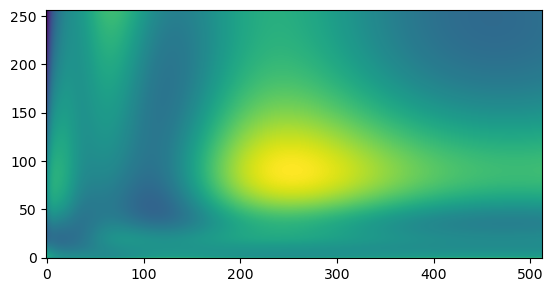

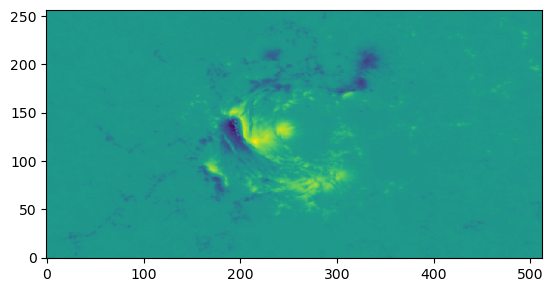

In [27]:
u = apply_fn(params, xt, yt, zt)
plt.figure()
plt.imshow(u[2, :, :, 0].transpose(), origin='lower')

plt.figure()
plt.imshow(b[2, :, :, 0].transpose(), origin='lower')

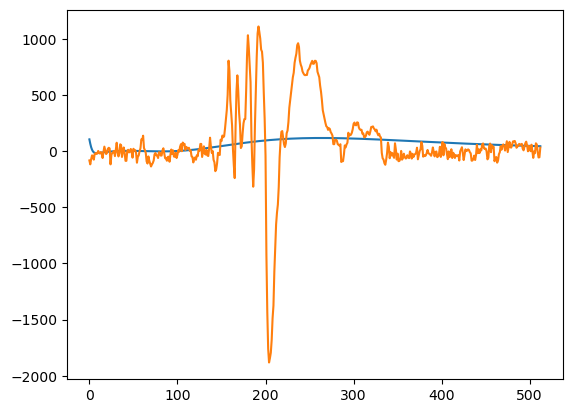

In [13]:
aaa = u[0, :, :, 0].transpose()
ccc = b[0, :, :, 0].transpose()

plt.plot(aaa[120, :])
plt.plot(ccc[120, :])

In [19]:
nc = 4
xb_p = jax.random.randint(subkey, (nc, 1), minval=0, maxval=512)
yb_p = jax.random.randint(subkey, (nc, 1), minval=0, maxval=256)
# zb_p = jax.random.randint(subkey, (nc, 1), minval=0, maxval=256)
zb_p = jnp.array([[0]])
# xb = jnp.array([[0]])
u = apply_fn(params, xb_p, yb_p, zb_p).squeeze()

In [20]:
u

Array([[[  41.733345  ,   65.947685  ,  108.98042   ,   -0.29000473],
        [ -22.836205  ,    6.5988045 ,   61.84036   ,   -1.2202396 ],
        [  -1.6124916 ,   18.674126  ,   54.3515    ,  -18.572086  ],
        [  45.116882  ,   72.19169   ,  121.29433   ,    9.710535  ]],

       [[  67.76785   ,   81.434494  ,  118.76987   ,   40.190872  ],
        [ -70.47662   ,  -56.382515  ,  -17.439524  ,  -33.173508  ],
        [  63.051277  ,   76.122574  ,  111.974785  ,   44.93775   ],
        [  -1.5905123 ,   12.371025  ,   50.71147   ,    2.3407497 ]],

       [[  45.44039   ,   60.772785  ,  116.2996    ,   25.554821  ],
        [-113.461754  ,  -91.625114  ,  -18.238892  ,  -54.215775  ],
        [ -71.96228   ,  -64.861115  ,  -31.471085  ,  -66.18174   ],
        [  53.963547  ,   74.01987   ,  142.31233   ,   42.287975  ]]],      dtype=float32)

In [21]:
xb_p_m, yb_p_m, zb_p_m = np.meshgrid(xb_p, yb_p, zb_p, indexing='ij')

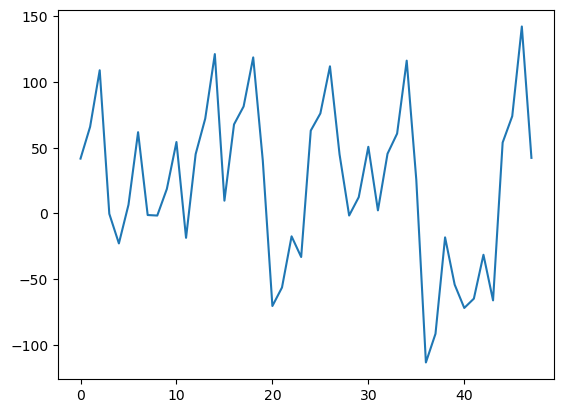

In [22]:
plt.plot(u.ravel())

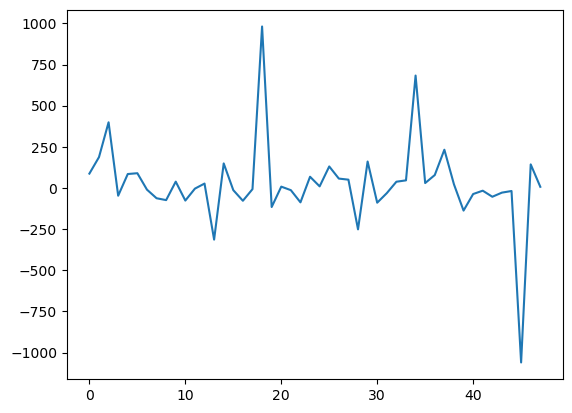

In [23]:
plt.plot(b[:, xb_p_m.ravel(), yb_p_m.ravel(), zb_p_m.ravel()].ravel())

In [211]:
k = b[:, 0, :, :]

In [212]:
k[:, yb_p_m.ravel(), zb_p_m.ravel()].ravel()

array([  0.69899333,   0.91685039,   1.64152324,  15.38521576,
         0.69800121,   0.91567832,   1.64201093,  15.67801666,
         0.73386973,   0.97439265,   1.80721426,  16.40563011,
         0.79535955,   1.07174873,   2.05279303,  15.81293392,
         0.11052569,   0.16371682,   0.37930089,   3.81057096,
         0.14967144,   0.21013246,   0.41321987,  -1.07692623,
         0.13381943,   0.1719041 ,   0.23343121,  -5.97059155,
        -0.146455  ,  -0.19139211,  -0.28258145,   4.15247583,
         3.70974946,   3.29227853,   2.09402156,   8.55581284,
         3.7582438 ,   3.36024094,   2.22857642,   8.06589603,
         3.86174679,   3.48794246,   2.37123966,  -0.77531302,
         3.70306778,   3.23655891,   1.68017936, -16.34046745])

In [113]:
bbb = k[0, ...]
bbb

array([[ 15.59000015,  35.0013504 ,  36.377491  , ...,   0.36098519,
          0.35527438,   0.34965375],
       [ 49.43000031,  31.31114388,  34.60973358, ...,   0.36141965,
          0.35569692,   0.35006467],
       [ 26.44000053,  33.457798  ,  33.72734833, ...,   0.36185512,
          0.35612041,   0.3504765 ],
       ...,
       [ 38.25999832,  40.8993721 ,  38.17782211, ...,   0.3601203 ,
          0.35443327,   0.3488358 ],
       [-34.06000137,  41.2420578 ,  37.99271011, ...,   0.36055198,
          0.35485306,   0.34924406],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [117]:
aaa.ravel().shape

(16,)

In [116]:
bbb[yb_p_m.ravel(), zb_p_m.ravel()].shape

(16,)

In [89]:
k = b[:, 0, :, :]
k[:, yb_p.ravel(), zb_p.ravel()].shape

(3, 64)

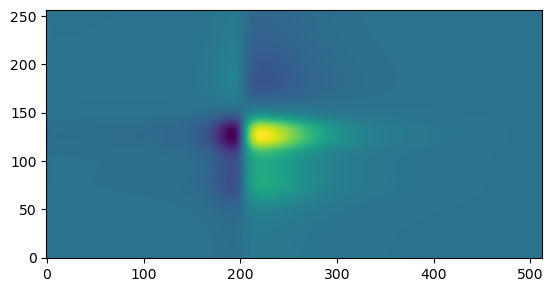

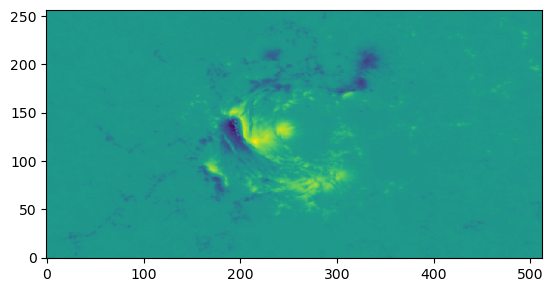

In [59]:
u = apply_fn(params, xt, yt, jnp.array([[0]])).squeeze()
bz_z0 = u[2, :, :]
plt.figure()
plt.imshow(bz_z0.transpose(), origin='lower')

plt.figure()
plt.imshow(b[2, :, :, 0].transpose(), origin='lower')

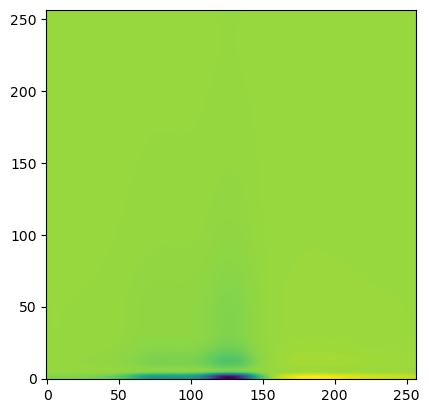

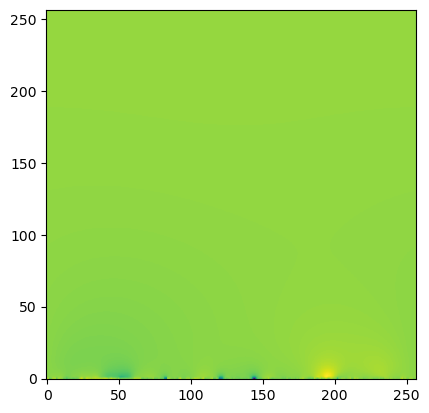

In [60]:
u = apply_fn(params, jnp.array([[0]]), yt, zt).squeeze()
bz_x0 = u[2, :, :]
plt.figure()
plt.imshow(bz_x0.transpose(), origin='lower')

plt.figure()
plt.imshow(b[2, 0, :, :].transpose(), origin='lower')